In [466]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

MeanSquaredError:  4304.25
Accuracy:  0.023006624287328685
Keras Accuracy:  5.663554
Keras Precision:  1.0


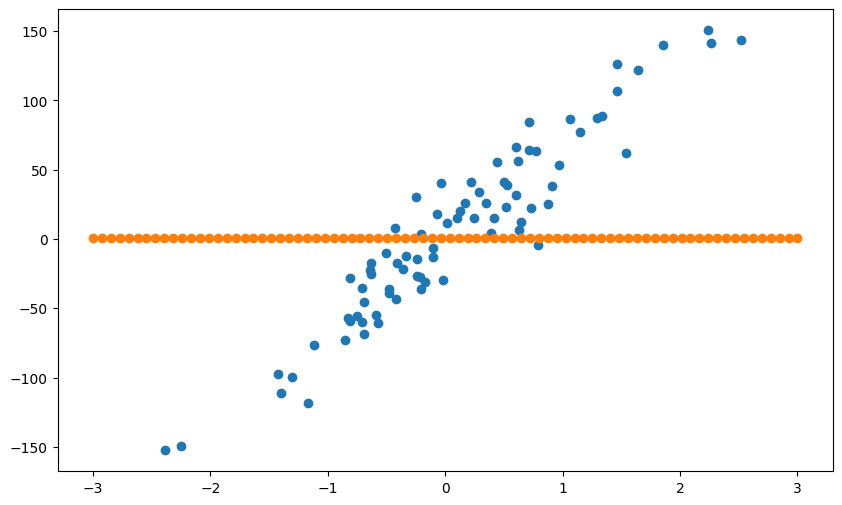

In [488]:
class Layer(tf.Module):
    def __init__(self, n_features, n_output, neurons=30, activation=tf.identity, i=1):
        self.neurons = neurons
        self.activation = activation
        self.build = False
        self.normalized = False
        self.index = i
        self.weights = tf.Variable(self.xavier_init(shape=(n_features, self.neurons)), name="Weights", dtype=tf.double, trainable=True )
        self.bias = tf.Variable(tf.zeros(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )

    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        return weight_vals

    def __call__(self, X, y):
        if self.index % 2 != 0:
            z = tf.add(tf.matmul(X, self.weights), self.bias)
        else:
            z = tf.add(tf.matmul(X, tf.transpose(self.weights)), self.bias)

        #print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return self.activation(z)

    

class MLPLinearRegressor(tf.Module):
    def __init__(self, X, y, layers, lr=0.001):
        self.X = X
        self.y = y
        self.layers = layers
        self.optimizer = tf.keras.optimizers.Adam(lr)
        self.mse = tf.keras.metrics.MeanSquaredError()
        self.accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.precision = tf.keras.metrics.Precision()

    @tf.function(reduce_retracing=True)
    def accuracy_rrsse(self, predicted):
        return tf.divide(tf.sqrt(
            tf.divide(
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(predicted, tf.sigmoid(self.y)))))),
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(tf.reduce_mean(tf.sigmoid(self.y)), predicted)))))
            )), len(predicted)
        )

    def normalize_dataset(self, X):
        return tf.convert_to_tensor(tf.keras.utils.normalize(X))


    @tf.function(reduce_retracing=True)
    def loss(self, predicted):
        #return 1/2 * tf.reduce_sum( tf.square(tf.subtract(tf.sigmoid(self.y), tf.squeeze(predicted))))
        return tf.losses.mean_squared_error(self.y, predicted)

    def calc_metrics(self, y_pred):
        self.acc_rrsse = self.accuracy_rrsse(y_pred)
        self.accuracy.update_state(self.y, self.y_pred)
        self.precision.update_state(self.y, self.y_pred)
        self.mse.update_state(self.y, self.y_pred)

    def train_step(self, X, y):
        for layer in self.layers:
            X = layer(X, y)
        return X
           
    def train(self, epochs=1, lr=0.001):
        XN = self.normalize_dataset(self.X)
        for e in range(epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.y_pred = tf.squeeze(model.train_step(XN, self.y))
                loss = self.loss(self.y_pred)
            self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights, self.layers[0].bias, self.layers[1].bias]

            grads = tape.gradient(loss, self.vars) 
            self.optimizer.apply_gradients(zip(grads, self.vars))
        self.calc_metrics(self.y_pred)



X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=100, n_features=2, noise=0, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

model = MLPLinearRegressor(X_train2, y_train2, [
    Layer(X_train2.shape[1], y_train2.shape[0], neurons=50,activation=tf.nn.relu, i=1),
    Layer(X_train2.shape[1], y_train2.shape[0], neurons=50,activation=tf.nn.relu, i=2),
    Layer(X_train2.shape[1], y_train2.shape[0], neurons=1,activation=tf.sigmoid, i=3)
])
model.train(epochs=100, lr=0.001)


print("MeanSquaredError: ", model.mse.result().numpy())
print("Accuracy: ", model.acc_rrsse.numpy())
print("Keras Accuracy: ", model.accuracy.result().numpy())
print("Keras Precision: ", model.precision.result().numpy())

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train2[:, 0], y_train2[:])
ax.scatter(np.linspace(-3, 3, num=model.y_pred.shape[0]), model.y_pred[:])
plt.show()

